In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator, InterpolatedUnivariateSpline, UnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
from matplotlib.lines import Line2D
from copy import deepcopy
from tools import *
from settings import *

### Cartopy

In [3]:
print("\U0001F63B")

😻


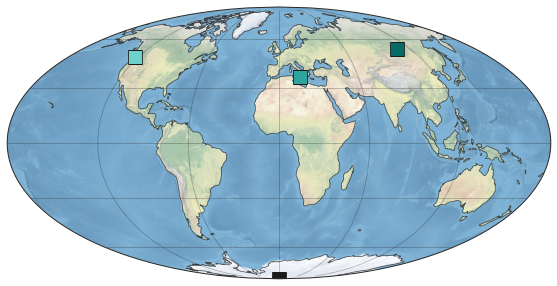

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.Mollweide())
ax.set_global()
ax.stock_img()
ax.coastlines(color="k", alpha=0.7)
gl = ax.gridlines(draw_labels=False, alpha=0.3, color="k", ls=":")

for i, (name, new_pole) in enumerate(sorted(poles.items())):
    if "Plenum" in name or "Gen" in name: continue
    ax.scatter(
        np.degrees(new_pole["lon"]), np.degrees(new_pole["lat"]),
        s=170, alpha=1,
        marker='s', c=[new_pole["color"]], 
        edgecolors="k",
        label=name,
        transform=ccrs.PlateCarree(),
        zorder=10
    )
plt.savefig("../plots/map_overview.pdf")

### First, get all effective areas

In [23]:
from aeff_calculations import get_aeff_and_binnings

In [24]:
aeff_2d, log_ebins, ebins, sindec_bins, ra_bins = get_aeff_and_binnings("full")

emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)
ra_mids = get_mids(ra_bins)
ra_width = np.diff(ra_bins)

40 log_10(energy) bins
50 declination bins
100 RA bins


## Catalogs

In [25]:
_3FHL = np.load('../resources/3FHL_All_2019.npy')
_4FGL = np.load('../resources/4FGL.npy')

tracks = np.load('../resources/tracks.npy')
ang_unc = np.empty(len(tracks), dtype=float)
for i, ra_err in enumerate(tracks['ra_err']):
    name = tracks['name'][i]
    if b'HES' in name and not b'AHES' in name:
        ang_unc[i] = ra_err[0]
    else:
        Dec_err = np.mean([tracks['dec_err'][i][0], -tracks['dec_err'][i][1]])
        Ra_err = np.mean([ra_err[0], -ra_err[1]])
        ang_unc[i] = conv2ang_uncertainty(Ra_err,Dec_err, tracks['dec'][i])
tracks = np.lib.recfunctions.append_fields(
    tracks, names='sigma', data=ang_unc, dtypes=float, usemask=False)

# Create a skymap including the ps detection efficiency and all HE tracks 

## get all detection efficiencies $\propto N_{detected}$ per fixed livetime

In [83]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    tcks, padded_sd = pickle.load(f)

### detection efficiency -- IceCube only

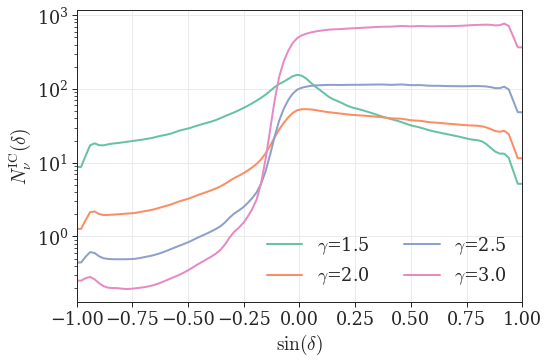

In [99]:
sindec_vals = np.linspace(-1, 1, 100)
gammas = [1.5, 2.0, 2.5, 3.]
fig, ax = plt.subplots(figsize=(8,6))
for gamma in gammas:
    eff = np.exp(tcks[gamma]["IceCube"](sindec_vals)) * LIVETIME * PHI_0
    p = ax.plot(sindec_vals, eff, label=r'$\gamma$={0:.1f}'.format(gamma))
    
ax.legend(ncol=2, frameon=False, loc=4)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$N_{\nu}^{\rm IC}(\delta)$')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
fig.tight_layout()
plt.subplots_adjust(top=0.85)

### all detectors -- equal contribution -- detection efficiency relative to icecube at respective declination

1.5
2.0
2.5
3.0


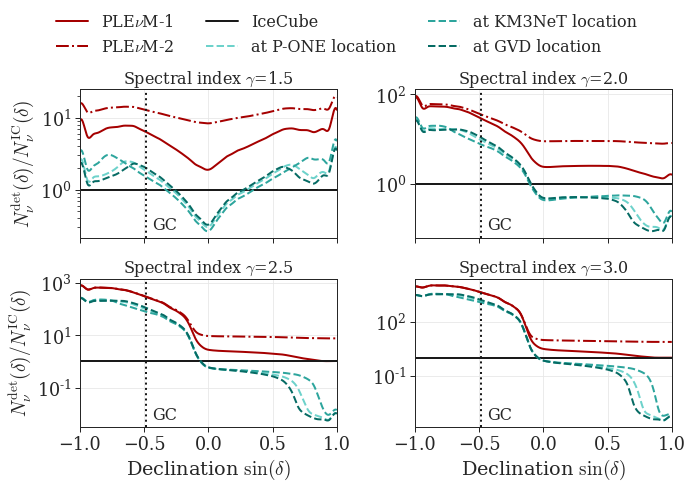

In [35]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(
    nrows=2, ncols=2, 
    sharex=True,
    figsize=(10, 7)
)
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        if "Gen" in det: continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(tcks[gamma]["IceCube"](sindec_vals))
        p = ax.plot(
            sindec_vals, Res, 
            label=poles[det]["label"] if ii==0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2
        )
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    #ax.axvline(np.sin(txs.icrs.dec), color="k", ls=":")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    print(gamma)
    if False:
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-1"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-1"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at TXS:", improv_txs)
        print("PLENUM-1 Improv at M77:", improv_m77)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-2"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-2"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at TXS:", improv_txs)
        print("PLENUM-2 Improv at M77:", improv_m77)
    
axes[2].set_xlabel(r'Declination $\sin(\delta)$')
axes[3].set_xlabel(r'Declination $\sin(\delta)$')
axes[0].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$')
axes[2].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$')
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.82)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec.pdf")

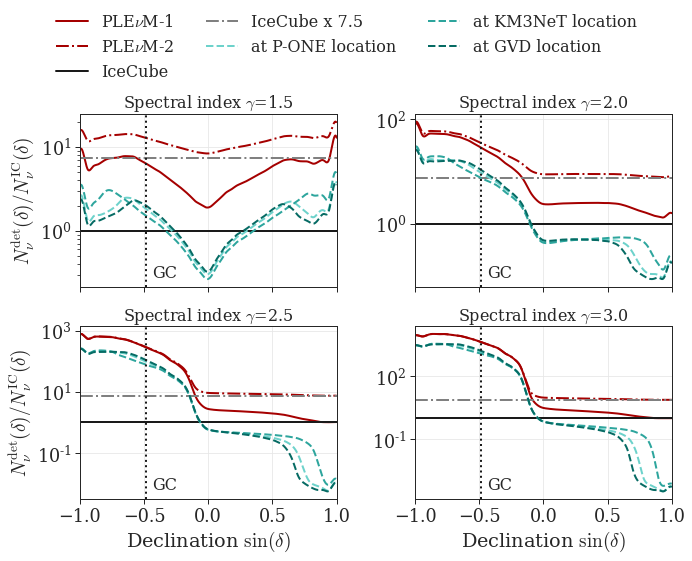

In [36]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(
    nrows=2, ncols=2, 
    sharex=True,
    figsize=(10, 8)
)
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(tcks[gamma]["IceCube"](sindec_vals))
        p = ax.plot(
            sindec_vals, Res, 
            label=poles[det]["label"] if ii==0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2
        )
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    #ax.axvline(np.sin(txs.icrs.dec), color="k", ls=":")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    if False:
        print(gamma)
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-1"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-1"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at TXS:", improv_txs)
        print("PLENUM-1 Improv at M77:", improv_m77)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-2"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-2"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at TXS:", improv_txs)
        print("PLENUM-2 Improv at M77:", improv_m77)
    
    
axes[2].set_xlabel(r'Declination $\sin(\delta)$')
axes[3].set_xlabel(r'Declination $\sin(\delta)$')
axes[0].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$')
axes[2].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$')
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec_wGen2.pdf")

2.0
PLENUM-1 Improv at GC: 28.542782983830797
PLENUM-1 Improv at TXS: 2.384805430872826
PLENUM-1 Improv at M77: 2.3684391644346006
PLENUM-2 Improv at GC: 35.020940815877715
PLENUM-2 Improv at TXS: 8.86154535851413
PLENUM-2 Improv at M77: 8.84400226196566
3.0
PLENUM-1 Improv at GC: 4112.268347709846
PLENUM-1 Improv at TXS: 2.596960293381603
PLENUM-1 Improv at M77: 3.0768173140426716
PLENUM-2 Improv at GC: 4118.747486367378
PLENUM-2 Improv at TXS: 9.073674664725496
PLENUM-2 Improv at M77: 9.541730672654635


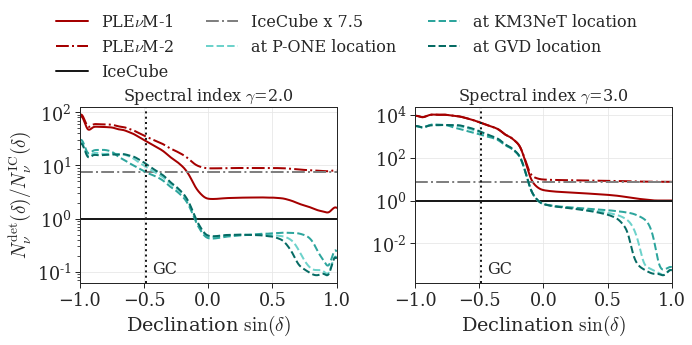

In [13]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(
    ncols=2, 
    sharex=True,
    figsize=(10, 5)
)
axes = axes.flatten()
for ii, gamma in enumerate([2.0, 3.0]):
    ax = axes[ii]
    for det in tcks[gamma]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(tcks[gamma]["IceCube"](sindec_vals))
        p = ax.plot(
            sindec_vals, Res, 
            label=poles[det]["label"] if ii==0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2
        )
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    #ax.axvline(np.sin(txs.icrs.dec), color="k", ls=":")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    if False:
        print(gamma)
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-1"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-1"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at TXS:", improv_txs)
        print("PLENUM-1 Improv at M77:", improv_m77)

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec)))
        improv_txs = np.exp(tcks[gamma]["Plenum-2"](np.sin(txs.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(txs.icrs.dec)))
        improv_m77 = np.exp(tcks[gamma]["Plenum-2"](np.sin(m77.icrs.dec)))\
                  / np.exp(tcks[gamma]["IceCube"](np.sin(m77.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at TXS:", improv_txs)
        print("PLENUM-2 Improv at M77:", improv_m77)    
    
axes[0].set_xlabel(r'Declination $\sin(\delta)$')
axes[1].set_xlabel(r'Declination $\sin(\delta)$')
axes[0].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$')
fig.legend(loc="upper center", ncol=3, frameon=False, fontsize="small")
fig.tight_layout()
plt.subplots_adjust(top=0.7)
fig.savefig("../plots/relative_detection_eff_dIC_vs_sindec_wGen2_smaller.pdf")

## improvement for specific sources

In [15]:
print(txs, m77)
gamma_txs = 2.1; n_txs = 12.3
gamma_m77 = 3.2; n_m77 = 50.4

<SkyCoord (ICRS): (ra, dec) in deg
    (77.36, 5.69)> <SkyCoord (ICRS): (ra, dec) in deg
    (40.67, -0.01)>


In [16]:
improv_txs_1 = np.exp(tcks[gamma_txs]["Plenum-1"](np.sin(txs.icrs.dec)))\
           / np.exp(tcks[gamma_txs]["IceCube"](np.sin(txs.icrs.dec)))
improv_txs_2 = np.exp(tcks[gamma_txs]["Plenum-2"](np.sin(txs.icrs.dec)))\
           / np.exp(tcks[gamma_txs]["IceCube"](np.sin(txs.icrs.dec)))
print("txs in icecube: n=", n_txs, "gamma=", gamma_txs,
      ", txs in plenum-1: n=", improv_txs_1 * n_txs, 
      ", txs in plenum-2: n=", improv_txs_2 * n_txs)

improv_m77_1 = np.exp(tcks[gamma_m77]["Plenum-1"](np.sin(m77.icrs.dec)))\
           / np.exp(tcks[gamma_m77]["IceCube"](np.sin(m77.icrs.dec)))
improv_m77_2 = np.exp(tcks[gamma_m77]["Plenum-2"](np.sin(m77.icrs.dec)))\
           / np.exp(tcks[gamma_m77]["IceCube"](np.sin(m77.icrs.dec)))
print("m77 in icecube: n=", n_m77, "gamma=", gamma_m77,
      ", m77 in plenum-1: n=", improv_m77_1 * n_m77, 
      ", m77 in plenum-2: n=", improv_m77_2 * n_m77)

txs in icecube: n= 12.3 gamma= 2.1 , txs in plenum-1: n= 29.53773254628838 , txs in plenum-2: n= 109.20162813812294
m77 in icecube: n= 50.4 gamma= 3.2 , m77 in plenum-1: n= 160.73524333192756 , m77 in plenum-2: n= 486.4897616462107


### all detectors -- detection efficiency 1D (sin dec) relative to icecube at horizon

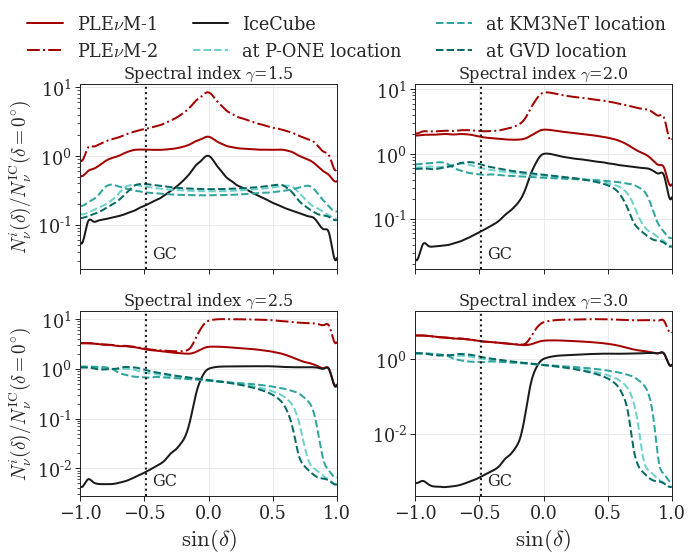

In [17]:
gammas = [1.5, 2.0, 2.5, 3.]
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    sharex=True, figsize=(10, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # detection efficiency of IceCube for specific spectral index at the horizon
    ## NOTE: maximum detection efficiency changes with spectral index, so we fix this to the horizon here
    arb_max_ic = np.exp(tcks[gamma]["IceCube"](0))
    for det in tcks[gamma]:
        if "Gen" in det: continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / arb_max_ic
        p = ax.plot(
            sindec_vals, Res, 
            label=poles[det]["label"] if ii==0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2
        )
    ax.set_title(r'Spectral index $\gamma$={0:.1f}'.format(gamma), fontsize="small")
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    #ax.axvline(np.sin(txs.icrs.dec), color="k", ls=":")
    ax.set_yscale('log')
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes, fontsize="small")
    
axes[2].set_xlabel(r'$\sin(\delta)$', fontsize="large")
axes[3].set_xlabel(r'$\sin(\delta)$', fontsize="large")
axes[0].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$')
axes[2].set_ylabel(r'$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$')
fig.legend(
    loc="upper center",
    ncol=3, frameon=False, 
)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.savefig("../plots/relative_detection_eff_d0_vs_sindec.pdf")

# Get the detection efficiency from each telescope for one time stamp

(repeat calculation from `alternative_plenum_aeff.ipynb`, but omit integral over RA)

In [41]:
with open("../resources/rel_events_ra_dec.pckl", "rb") as f:
    rel_events_ra_dec = pickle.load(f)
    
with open("../resources/inst_rel_events_ra_dec.pckl", "rb") as f:
    inst_rel_events_ra_dec = pickle.load(f)

### instantaneous field of view

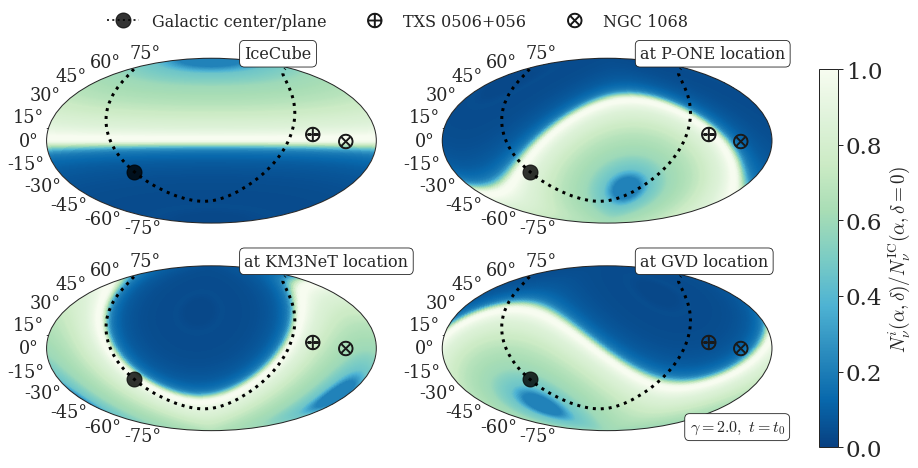

In [42]:
fig =  plt.figure(figsize=(13, 7))
n2ind = {'IceCube':221, 'P-ONE':222, 'KM3NeT':223, 'Baikal-GVD':224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name=="Gen-2": continue
    ax = fig.add_subplot(n2ind[name], projection='hammer', rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap='GnBu_r')
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        make_legend = False
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(
        0.6, 1.0, poles[name]["label"], 
        fontsize="small", transform = ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor="w", edgecolor="k"))
ax.text(
    0.75, 0, fr"$\gamma={gamma},~t=t_0$",
    transform = ax.transAxes, 
    fontsize="small",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="k")
)
fig.legend(
    fontsize="small", loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(fr'$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$')
cbar.ax.tick_params(labelsize="large")
fig.savefig('../plots/skymaps_local_time.pdf', bbox_inches="tight")

In [78]:
from tools import add_plane

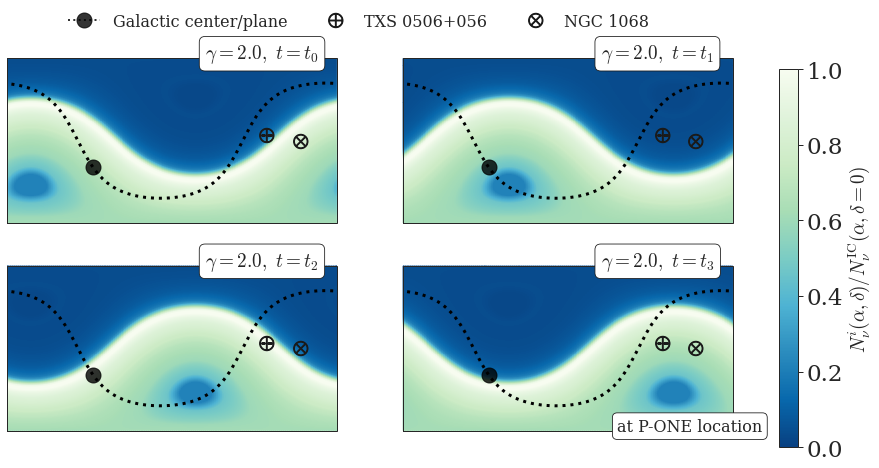

In [82]:
## only p-one
fig, axes =  plt.subplots(
    2, 2, figsize=(13, 7),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)
gamma = 2.0
make_legend = True
name = "P-ONE"
vals = inst_rel_events_ra_dec[gamma][name]
for i, clon in enumerate([0, 90, 180, 270]):
    ax = axes.flatten()[i]
    cax = ax.pcolormesh(
        np.rad2deg(ra_vals),# - clon,
        np.rad2deg(dec_vals), 
        vals,
        vmin=0, vmax=1, cmap='GnBu_r',
        transform=ccrs.PlateCarree(central_longitude=clon)
    )
    if make_legend:
        add_plane(ax, color='black',
                 transform=ccrs.PlateCarree())
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k',
               transform=ccrs.PlateCarree())
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k',
               transform=ccrs.PlateCarree())
        make_legend = False
    else:
        add_plane(ax, color='black', label='__None__',
                 transform=ccrs.PlateCarree())
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__',
               transform=ccrs.PlateCarree())
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__',
               transform=ccrs.PlateCarree())
    ax.text(
        0.6, 1.0, fr"$\gamma={gamma},~t=t_{i}$", 
        fontsize="medium", transform = ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor="w", edgecolor="k"))
ax.text(
    0.65, 0, poles[name]["label"],
    transform = ax.transAxes, 
    fontsize="small",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="k")
)
fig.legend(
    fontsize="small", loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(fr'$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$')
cbar.ax.tick_params(labelsize="large")
#fig.savefig('../plots/skymaps_local_time.pdf', bbox_inches="tight")

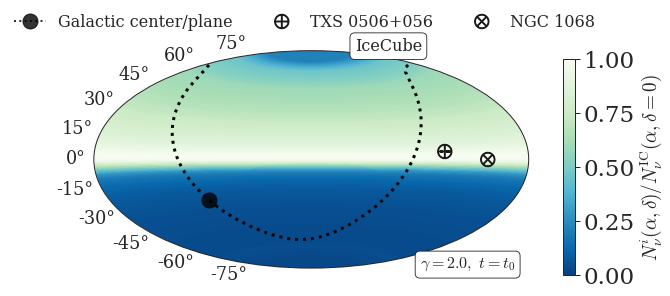

In [43]:
fig =  plt.figure(figsize=(8,4))
n2ind = {'IceCube':111}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(inst_rel_events_ra_dec[gamma].items()):
    if name!="IceCube": continue
    ax = fig.add_subplot(n2ind[name], projection='hammer', rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap='GnBu_r')
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        make_legend = False
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(
        0.6, 1.0, poles[name]["label"], 
        fontsize="small", transform = ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor="w", edgecolor="k"))
ax.text(
    0.75, 0, fr"$\gamma={gamma},~t=t_0$",
    transform = ax.transAxes, 
    fontsize="small",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="k")
)
fig.legend(
    fontsize="small", loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(fr'$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$')
cbar.ax.tick_params(labelsize="large")


## time integrated

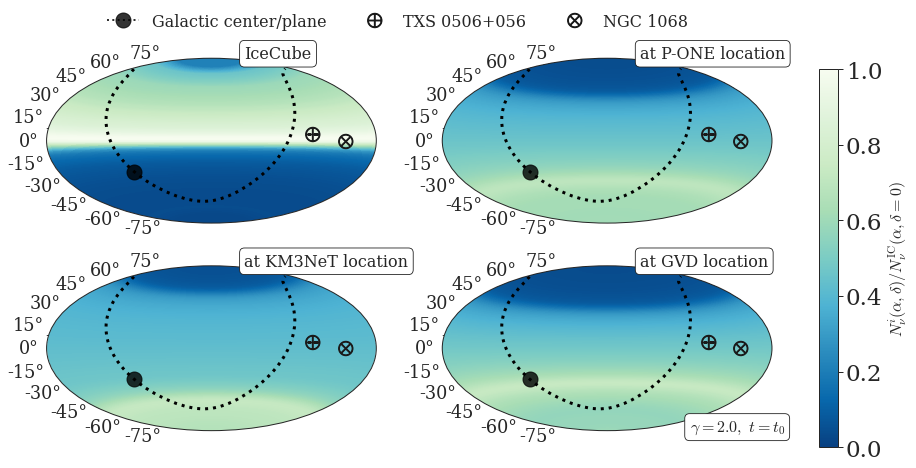

In [26]:
fig =  plt.figure(figsize=(13, 7))
n2ind = {'IceCube':221, 'P-ONE':222, 'KM3NeT':223, 'Baikal-GVD':224}
gamma = 2.0
make_legend = True
for i, (name, vals) in enumerate(rel_events_ra_dec[gamma].items()):
    if "Plenum" in name or name=="Gen-2": continue
    ax = fig.add_subplot(n2ind[name], projection='hammer', rasterized=True)
    cax = ax.pcolormesh(ra_vals - np.pi, dec_vals, vals, vmin=0, vmax=1, cmap='GnBu_r')
    # add the galactic center and plane
    if make_legend:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        make_legend = False
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(
        0.6, 1.0, poles[name]["label"], 
        fontsize="small", transform = ax.transAxes, 
        bbox=dict(boxstyle='round', facecolor="w", edgecolor="k"))
ax.text(
    0.75, 0, fr"$\gamma={gamma},~t=t_0$",
    transform = ax.transAxes, 
    fontsize="small",
    bbox=dict(boxstyle='round', facecolor="w", edgecolor="k")
)
fig.legend(
    fontsize="small", loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.9))
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_label(
    fr'$N_{{\nu}}^{{i}}(\alpha, \delta) / N_{{\nu}}^{{\rm IC}}(\alpha, \delta=0)$',
    fontsize="small")
cbar.ax.tick_params(labelsize="large")
fig.savefig('../plots/skymaps_time_integrated.pdf', bbox_inches="tight")

### integrated field of view

In [51]:
from tools import _trans

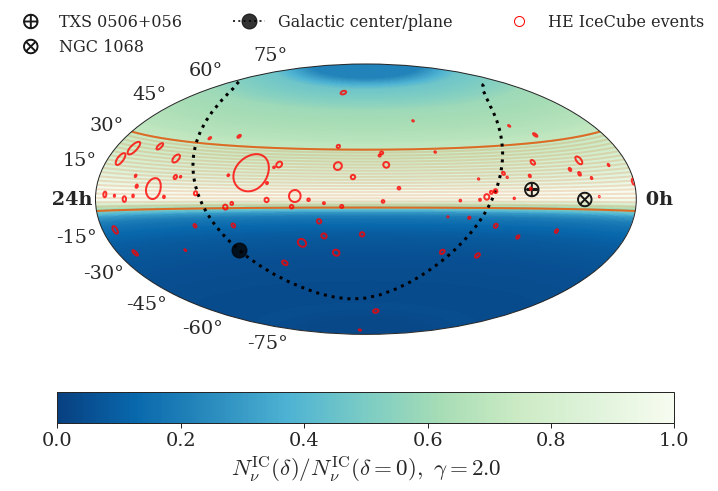

In [52]:
for gamma in [2.0]:
    fig = plt.figure(figsize=(10,7.))
    ax = fig.add_subplot(111, projection='hammer', rasterized=True)
    cax = ax.pcolormesh(
        ra_vals-np.pi, dec_vals, rel_events_ra_dec[gamma]["IceCube"], vmin=0, vmax=1, cmap='GnBu_r')
    cbar = fig.colorbar(cax, orientation='horizontal')
    cbar.set_label(fr'$N_{{\nu}}^{{\rm IC}}(\delta) / N_{{\nu}}^{{\rm IC}}(\delta=0),~\gamma={gamma}$', fontsize="large")
    cbar.ax.tick_params(labelsize="medium")
    #---------------------------------------
    # show the IceCube lines between -5 and 30 deg
    #---------------------------------------
    c = '#DC6C25'
    y1 = np.tile(np.radians(-5.), num)
    y2 = np.tile(np.radians(30), num)

    _x, _y1 =  _trans(ra_vals, y1)
    _x, _y2 =  _trans(ra_vals, y2)
    ind = np.argsort(_x)
    ax.plot(_x[ind], _y1[ind], color=c)
    ax.plot(_x[ind], _y2[ind], color=c)

    for y_i in np.linspace(-5, 30,num=20, endpoint=True): 
        ytmp = np.tile(y_i ,len(ra_vals))
        _x2, _y2 = _trans(ra_vals, np.radians(ytmp))
        ind = np.argsort(_x2)
        ax.plot(np.sort(_x2), _y2[ind], color=c, alpha=0.2)

    #  add also TXS and NGC1068
    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k') #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k') #DC6C25

    # add event with error radius
    for i, (rai, deci, si) in enumerate(zip(tracks['ra'], tracks['dec'], tracks['sigma'])):
        c='red'
        if i == 0:
            res = add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                labels=['IceCube HE events'], color=c, linewidths=2., zorder=10
            )
        else:
            add_event(
                ax, ra_i=np.radians(rai), dec_i=np.radians(deci),
                sigma_i=np.radians(si),
                color=c, linewidths=2.,zorder=10
            )

    # fix the labels
    set_ticks(ax, fs="medium")
    # add the galactic center and plane
    add_plane(ax, color='black')

    #get all legend entries and add the circle for the HE events
    handles, labels = ax.get_legend_handles_labels()
    HE_events = Line2D(
        range(1), range(1), color="red", 
        marker='o', markersize=10, markerfacecolor="None",
        linewidth=0, label='HE IceCube events'
    )
    handles.append(HE_events)
    fig.legend(
        handles=handles, fontsize="small",
        mode='expand',
        ncol=3, frameon=False
    )

    fig.tight_layout()
    plt.subplots_adjust(top = 0.87) #, bottom=0.2)
    fig.savefig(
        f'../plots/IceCube_Skymap_horizon_gamma{int(np.round(gamma*10))}.pdf',
        bbox_inches="tight", dpi=200)
    plt.show()

# Show a skymap with 4 time snippets of the cumulative view of the best field 
# of view of all existing telescopes

### IceCube only, all day, every day 

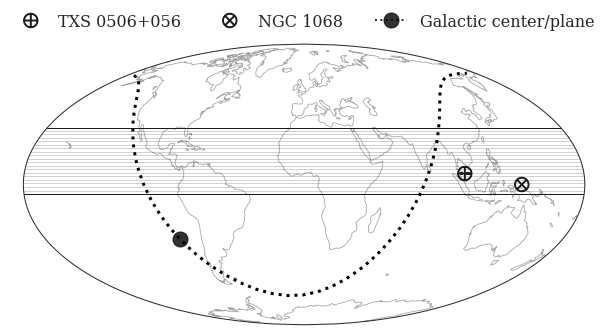

In [28]:
f, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.Mollweide())) 
ax.set_global()
ax.coastlines(color="gray", alpha=0.7)

ax.plot(np.rad2deg(ra_vals), np.rad2deg(y1), color=poles["IceCube"]["color"], transform=ccrs.PlateCarree(), lw=1)
ax.plot(np.rad2deg(ra_vals), np.rad2deg(y2), color=poles["IceCube"]["color"], transform=ccrs.PlateCarree(), lw=1)

for y_i in np.linspace(-5, 30, num=20, endpoint=True):
    y_loc = np.tile(y_i, len(ra_vals))
    ax.plot(np.rad2deg(ra_vals), y_loc, color=poles["IceCube"]["color"], alpha=0.2, transform=ccrs.PlateCarree(), lw=1)
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree()) #DC6C25
add_plane(ax, color='black', transform=ccrs.PlateCarree())
ax.legend(
    fontsize="small", loc='lower center',
    ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.)
)
f.tight_layout()

IceCube
P-ONE
KM3NeT
Baikal-GVD


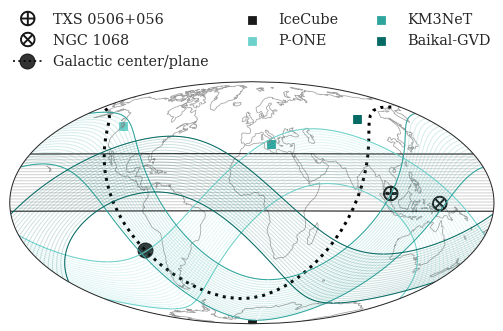

IceCube
P-ONE
KM3NeT
Baikal-GVD


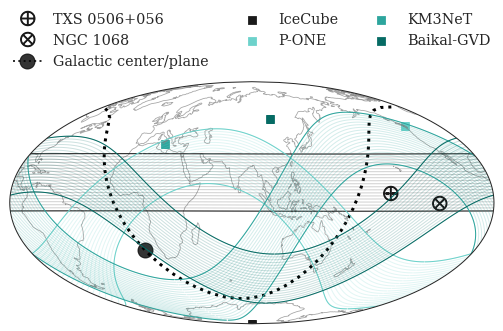

IceCube
P-ONE
KM3NeT
Baikal-GVD


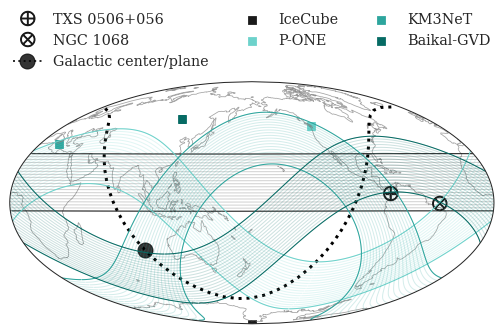

IceCube
P-ONE
KM3NeT
Baikal-GVD


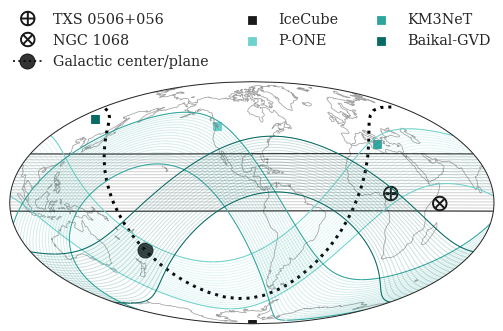

In [43]:
# loop through daily rotations
for ii, clon in enumerate([0, 90, 180, 270]):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=clon))
    ax.set_global()
    ax.coastlines(color="gray", alpha=0.7)

    # coordinate grid in equatorial coordinates (icrs)
    # these will be the integration coordinates
    eq_coords_low = SkyCoord(
        ra_vals * u.radian,
        -y1 * u.radian,
        frame="icrs"
    )
    eq_coords_up = SkyCoord(
        ra_vals * u.radian,
        -y2 * u.radian,
        frame="icrs"
    )

    ic_loc = EarthLocation(
        lat=poles["IceCube"]["lat"],
        lon=poles["IceCube"]["lon"],
    )

    add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', transform=ccrs.PlateCarree(central_longitude=clon)) #DC6C25
    add_plane(ax, color='black', transform=ccrs.PlateCarree(central_longitude=clon))

    # loop over detectors
    for i, (k, coord) in enumerate(poles.items()):
        if "Plenum" in k or k=="Gen-2": continue
        print(k)
        # local detector
        loc = EarthLocation(
            lat=coord["lat"],
            lon=coord["lon"],
        )
        time = Time('2021-4-20 00:00:00', scale="utc")
        # transform integration coordinates to local frame
        local_coords_low = eq_coords_low.transform_to(AltAz(obstime=time, location=loc))
        local_coords_up = eq_coords_up.transform_to(AltAz(obstime=time, location=loc))
        
        ind = np.argsort(local_coords_low.az.deg)
        ax.plot(local_coords_low.az.deg[ind] + loc.lon.deg, local_coords_low.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.plot(local_coords_up.az.deg[ind] + loc.lon.deg, local_coords_up.alt.deg[ind], transform=ccrs.PlateCarree(), lw=1, color=coord["color"])
        ax.scatter(loc.lon.deg, loc.lat.deg, color=coord["color"], marker="s", s=50, transform=ccrs.PlateCarree(), label=k)

        for y_i in np.linspace(-30, 5, num=20, endpoint=True):
            y_loc = np.tile(y_i, len(ra_vals))
            local_coords_tmp = SkyCoord(
                ra_vals * u.radian, y_loc * u.degree, frame="icrs"
            ).transform_to(AltAz(obstime=time, location=loc))
            ind = np.argsort(local_coords_tmp.az.deg)
            ax.plot(
                local_coords_tmp.az[ind].deg + loc.lon.deg, 
                local_coords_tmp.alt.deg[ind], 
                transform=ccrs.PlateCarree(), 
                lw=1, color=coord["color"], 
                alpha=0.2
            )
        ax.legend(
            fontsize="x-large", loc='lower center',
            ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.)
        )
        fig.tight_layout()
        fig.savefig(f"../plots/best_field_of_view_map_{ii}.png")
    plt.show()

# Plenum improvements for gamma=2 and the same amount of time

This plot shows a direct comparison of plenum and IceCube for equal run times

### Idea:
* Discovery potential improvement:

$R = \frac{\Phi_0}{\Phi_{\rm new}} = \left( \frac{t_0}{t_{\rm new}} \right)^{-0.8} = \left( \frac{t_{\rm new}}{t_0} \right)^{0.8} = \left( \frac{\int dE \cdot A_{\rm eff, new} \cdot d\Phi/dE}{\int dE A_{\rm eff, 0} \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at horizon $(\delta=0)$:

$R_0 = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta=0) \cdot d\Phi/dE} \right)^{0.8}$

* Improvement relative to IceCube at resp. declination:

$R_{rel} = \left( \frac{\int dE \cdot A_{\rm eff, new}(\delta) \cdot d\Phi/dE}{\int dE \cdot A_{\rm eff, IC}(\delta) \cdot d\Phi/dE} \right)^{0.8}$

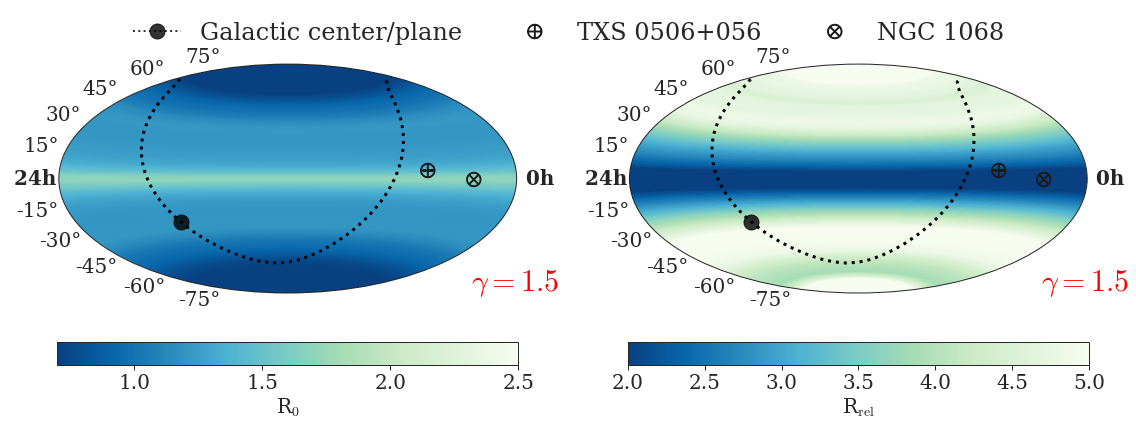

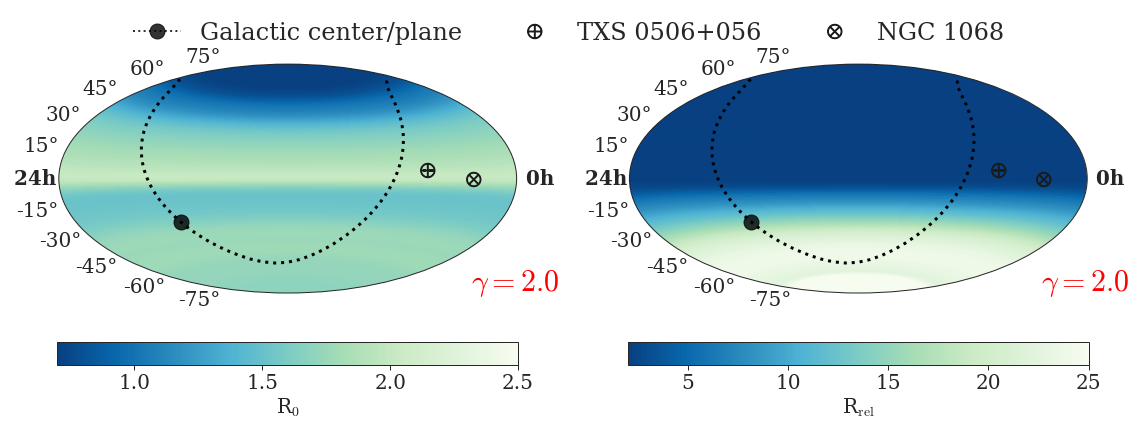

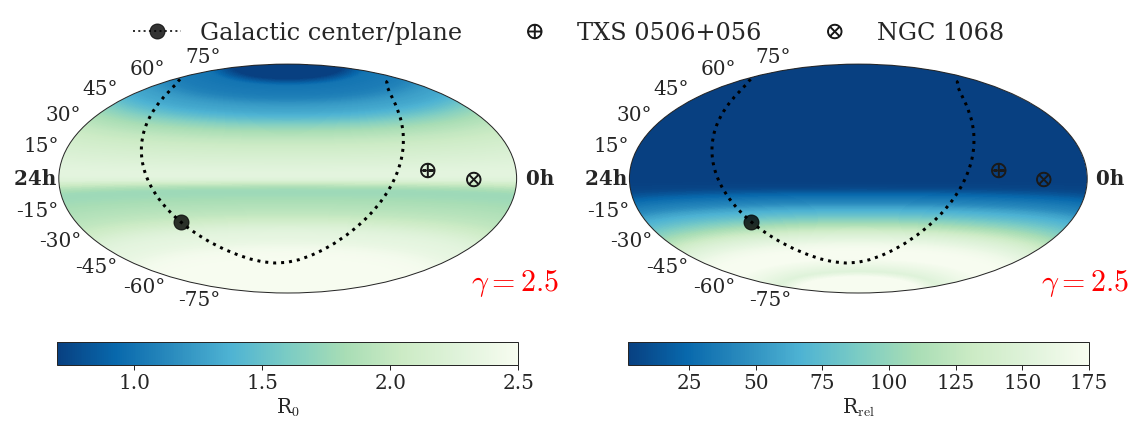

In [44]:
i2ind = {0:121, 1:122}
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.5: {'r0': (0.7, 2.5), 'rrel':(2., 5.)},
    2.0: {'r0': (0.7, 2.5), 'rrel':(2., 25.)},
    2.5: {'r0': (0.7, 2.5), 'rrel':(2., 175.)},
}

for gamma in [1.5, 2.0, 2.5]:
    fig =  plt.figure(figsize=(16, 6))
    for i, vari in enumerate(variation):
        ax = fig.add_subplot(i2ind[i], projection='hammer', rasterized=True)
        comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
        
        if vari == 'rrel':
            mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
            comb_vals[mask] = (rel_events_ra_dec[gamma]["Plenum"][mask] \
                               / rel_events_ra_dec[gamma]["IceCube"][mask]) ** 0.8
        else:
            comb_vals = (rel_events_ra_dec[gamma]["Plenum"] \
                         / rel_events_ra_dec[gamma]["IceCube"][len(rel_events_ra_dec[gamma]["IceCube"]) // 2]) ** 0.8
        _min, _max = extreme[gamma][vari]

        cax = ax.pcolormesh(
            ra_vals - np.pi, dec_vals, 
            comb_vals, 
            vmin=_min, vmax=_max,
            cmap='GnBu_r')

        cbar = fig.colorbar(cax,  orientation='horizontal')
        cbar.ax.tick_params(labelsize=fs)
        cbar.set_label(labels[vari], fontsize=fs)
        set_ticks(ax, fs=fs)
        # add the galactic center and plane
        if i==0:
            add_plane(ax, color='black')
            add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
            add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
        else:
            add_plane(ax, color='black', label='__None__')
            add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
            add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
        ax.text(
            .9, .01, fr"$\gamma={gamma}$", 
            ha='left', size=fs+10, transform=ax.transAxes, color='red')

    fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
    fig.tight_layout()
    plt.subplots_adjust(top = 0.84)#, bottom=0.2)
    # fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)

# Show the time evolution of plenum

----

This plot will show how plenum improves (after x years) the total discovery potential if we turn it on after 10years of IceCube 

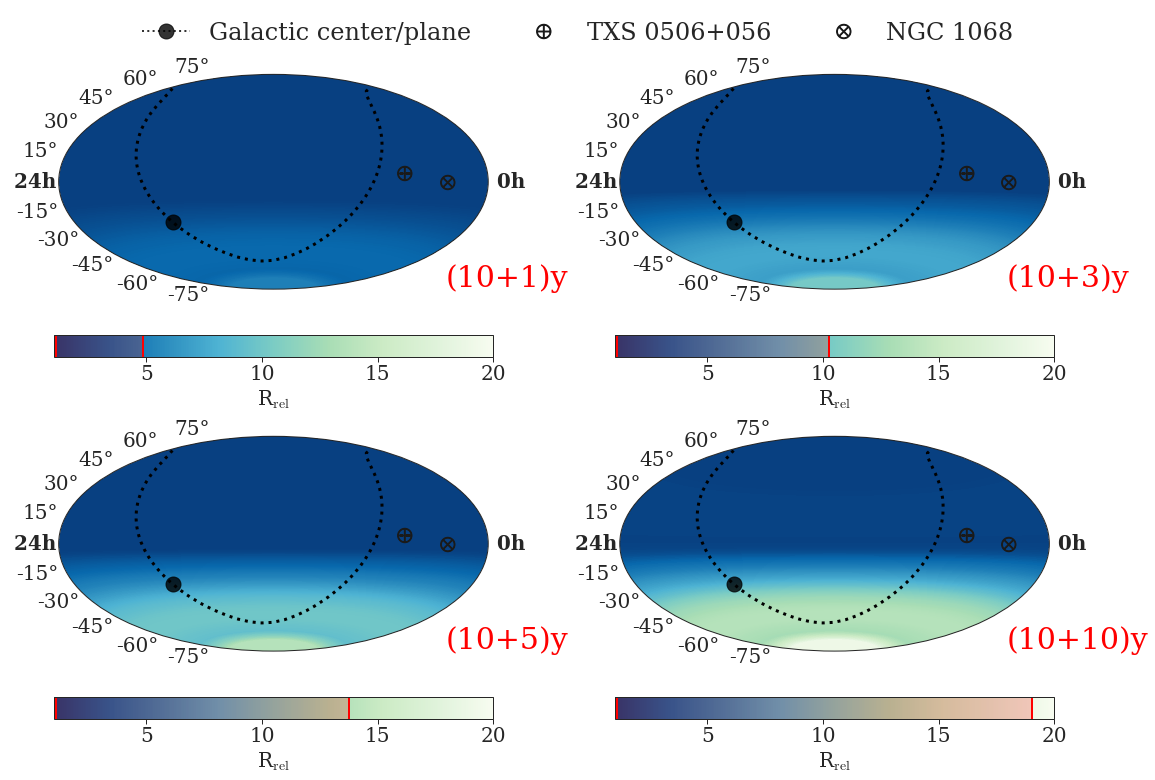

In [45]:
i2ind = { 0:221, 1:222, 2:223, 3:224 }
# Options:
# R0: comparison to IceCube at horizon
# R_rel: comparison to IceCube at respective declination
variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
# min, max for colorbar, because there are some numeric hiccups at the poles
extreme = {
    1.:  (1., 20.),
    3.:  (1., 20.),
    5.:  (1., 20.),
    10.: (1., 20.)
}
t_0 = 10. # years
t_news = [1., 3., 5., 10.] # years
gamma = 2.0
fig =  plt.figure(figsize=(16, 11))
vari = "rrel"

for i, t_new in enumerate(t_news):
    comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
    ax = fig.add_subplot(i2ind[i], projection='hammer', rasterized=True)
    
    mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
    comb_vals[mask] = (rel_events_ra_dec[gamma]["Plenum"][mask] \
                       / rel_events_ra_dec[gamma]["IceCube"][mask] \
                      * t_new/(t_0 + t_new)) ** 0.8
    _min, _max = extreme[t_new]
    cax = ax.pcolormesh(
        ra_vals - np.pi, dec_vals,
        comb_vals, 
        vmin=_min, vmax=_max,
        cmap='GnBu_r'
    )
    cbar = fig.colorbar(cax,  orientation='horizontal')
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(labels[vari], fontsize=fs)
    
    cmarker_0 = _min + 0.005*(_max - _min)
    cmarker_1 = np.max(comb_vals)
    cbar.ax.axvline(cmarker_0, color='red', lw=2)
    cbar.ax.axvline(cmarker_1, color='red', lw=2)
    # I have no idea how fill_between works for color axes :D
    cbar.ax.fill_between([cmarker_0, cmarker_1], [-1, -1],[50, 50], color='red', alpha=0.2)
    
    set_ticks(ax, fs=fs)
    # add the galactic center and plane
    if i==0:
        add_plane(ax, color='black')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')
    else:
        add_plane(ax, color='black', label='__None__')
        add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
        add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')
    ax.text(
        .9, .01, r"({1:d}+{0:d})y".format(int(t_new), int(t_0)), 
        ha='left', size=fs+10, transform=ax.transAxes, color='red')

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top = 0.9)#, bottom=0.2)
# fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)

# Show ratio including Gen2 

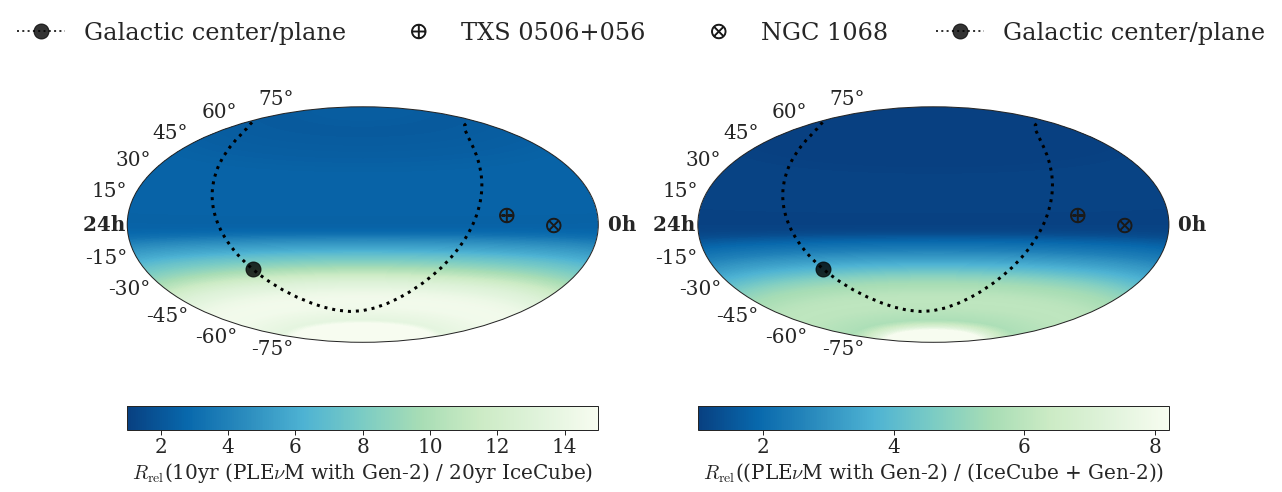

In [46]:
gamma = 2.0
fig =  plt.figure(figsize=(16, 7))
vari = "rrel"
_min, _max =  (1., 15.)

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0

ax = fig.add_subplot(121, projection='hammer', rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 20yrs of IceCube
comb_vals[mask] = ((rel_events_ra_dec[gamma]["Plenum"][mask] - rel_events_ra_dec[gamma]["IceCube"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask]) \
                   / rel_events_ra_dec[gamma]["IceCube"][mask] \
                  * 0.5) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals,
    comb_vals, 
    vmin=_min, vmax=_max,
    cmap='GnBu_r'
)
cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$(10yr (PLE$\nu$M with Gen-2) / 20yr IceCube)', fontsize=fs)

set_ticks(ax, fs=fs)
# add the galactic center and plane
add_plane(ax, color='black')
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k')
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k')

comb_vals = np.zeros_like(rel_events_ra_dec[gamma]["IceCube"])
mask = rel_events_ra_dec[gamma]["IceCube"] > 0.0
ax = fig.add_subplot(122, projection='hammer', rasterized=True)
## 10yrs of Plenum including Gen-2 (subtracting IceCube events from original Plenum events)
## vs 10yrs of IceCube plus 10yrs of Gen2
comb_vals[mask] = ((rel_events_ra_dec[gamma]["Plenum"][mask] - rel_events_ra_dec[gamma]["IceCube"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask]) \
                   / (rel_events_ra_dec[gamma]["IceCube"][mask] + rel_events_ra_dec[gamma]["Gen-2"][mask])) ** 0.8
cax = ax.pcolormesh(
    ra_vals - np.pi, dec_vals,
    comb_vals, 
    vmin=_min,# vmax=_max,
    cmap='GnBu_r'
)
cbar = fig.colorbar(cax,  orientation='horizontal')
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'$R_{\mathrm{rel}}$((PLE$\nu$M with Gen-2) / (IceCube + Gen-2))', fontsize=fs)

set_ticks(ax, fs=fs)
# add the galactic center and plane
add_plane(ax, color='black')
add_obj(ax, "txs", marker=r'$\bigoplus$', c='k', label='__None__')
add_obj(ax, "ngc", marker=r'$\bigotimes$', c='k', label='__None__')

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False)#,  mode='expand')
fig.tight_layout()
plt.subplots_adjust(top = 0.9)#, bottom=0.2)
# fig.savefig('plots/Plenum_g3_2.png', bbox_inches="tight", dpi=200)